In [1]:
from qiskit_qec.circuits.repetition_code import ArcCircuit
from qiskit_ibm_provider import IBMProvider
from qiskit_aer import AerSimulator, noise


from qiskit_qec.decoders import DecodingGraph
import pickle

from matplotlib import pyplot as plt
from random import shuffle
import numpy as np
import datetime

from utils import get_error_coords, schedule_heavy_hex

print('''
qiskit-terra	0.24.1
qiskit-aer	0.12.1
qiskit-ibmq-provider	0.20.2
qiskit	0.43.2
System information
Python version	3.10.6
Python compiler	Clang 12.0.0
Python build	main, Oct 24 2022 11:04:34
''')


qiskit-terra	0.24.1
qiskit-aer	0.12.1
qiskit-ibmq-provider	0.20.2
qiskit	0.43.2
System information
Python version	3.10.6
Python compiler	Clang 12.0.0
Python build	main, Oct 24 2022 11:04:34



We start by getting the backend we'll use. Here's `ibm_sherbrooke`.

In [2]:
simulator = True # choose whether to use a simulator

try:
    assert simulator == False
    provider = IBMProvider(instance='ibm-q-internal/deployed/default')
    backend = provider.get_backend('ibm_sherbrooke')
    simulator = False
except:
    if not simulator:
        print('No access to real device. proceeding with simulator')
    from qiskit.providers.fake_provider import FakeSherbrooke
    backend = FakeSherbrooke()
    simulator = True
num_qubits = backend.num_qubits
plot_backend = backend

Then we analyze it to get the links and schedules that the code will be based on.

In [3]:
links, schedule, triplets = schedule_heavy_hex(backend)

If you are running the code on a noisy simulator, this will be set up by the following.

In [4]:
if simulator:
    backend = AerSimulator()
    p_all = 0.05
    
    def get_noise_model(p_1,p_2,p_m):
        e_1 = noise.depolarizing_error(p_1, 1)
        e_2 = noise.depolarizing_error(p_2, 2)
        e_m = noise.pauli_error([('X',p_m),('I',1-p_m)])
        noise_model = noise.NoiseModel()
        noise_model.add_all_qubit_quantum_error(e_1, ['h', 'x', 'rz', 'sx'])
        noise_model.add_all_qubit_quantum_error(e_2, ['cx'])
        noise_model.add_all_qubit_quantum_error(e_m, ['measure'])
        return noise_model

    noise_model = get_noise_model(p_all,p_all,p_all)

The following cell will now run all the required circuits on your chosen backend. If you just want to look at previous data, then don't run it.

In [5]:
resets = True

if not simulator:
    delay = round((backend.properties().gate_length('reset',0)/backend.dt)/16)*16
for T in [10]: # set number of rounds to run for here
    circuits = []
    code = {}
    for logical in ['0', '1']:
        if resets:
            code[logical] = ArcCircuit(links,T,schedule=schedule,run_202=False,basis='zx',logical=logical,resets=True)
        else:
            code[logical] = ArcCircuit(links,T,schedule=schedule,run_202=False,basis='zx',logical=logical,resets=False,delay=delay)
        if not simulator:
            circuit = code[logical].transpile(backend)
        else:
            circuit = code[logical].circuit
        for basis in [code[logical].basis, code[logical].basis[::-1]]:
            circuits.append(circuit[basis])
    if not simulator:
        job = backend.run(circuits, shots=10000, rep_delay=backend.configuration().rep_delay_range[1])
    else:
        job = backend.run(circuits, shots=10000)
    for logical in ['0', '1']:
        with open('code_circuit/'+job.job_id()+'_'+logical+'.p', 'wb') as file:
            pickle.dump(code[logical], file)
    print('*', T, job.job_id())

* 10 b52e1695-0c1b-47cc-a796-0745faff3294


Here are some results I made earlier.


### 30th June 2023 `'ibm_sherbrooke'`  (ran on 3rd/4th July)

`resets=True`

* 1 ciff4mk60l54kv9p5r3g
* 10 ciff837985671v40uq40

`resets=False`, `delay=5856`

* 10 cifg0vc60l54kv9qhi30

`resets=True`, `backend=FakeSherbrooke()`

* 10 547460de-1663-47a7-b35f-db2b53b8bedb

`resets=True`, `p_all=0.01`

* 10 1348f289-c591-4035-9df1-6bb5c652bac7

Pick a job ID and put it below to load the results.

In [6]:
job_id = 'ciff4mk60l54kv9p5r3g'

code = {}
for logical in ['0', '1']:
    with open('code_circuit/'+job_id+'_'+logical+'.p', 'rb') as file:
        code[logical] = pickle.load(file)
dg = DecodingGraph(code['0'])

try:
    with open('result/'+job_id+'.p', 'rb') as file:
        result = pickle.load(file)
except:
    result = provider.retrieve_job(job_id).result()
    with open('result/'+job_id+'.p', 'wb') as file:
        pickle.dump(result, file)
raw_counts = result.get_counts()


For `shots=None` below, the full set of results is used. Otherwise, it's just a randomly sampled set of shots.

In [9]:
shots = None

if shots:
    counts = []
    for j in range(4):

        memory = []
        for string in raw_counts[j]:
            memory += [string]*raw_counts[j][string]
        shuffle(memory)

        counts.append({})
        for string in set(memory[0:shots]):
            counts[j][string] = raw_counts[j][string]
else:
    counts = raw_counts

The cell below calculates the probabilities of errors for each edge in the decoding graph, or loads previously calculated data if available.

In [10]:
try:
    with open('probs/'+job_id+'_'+str(shots)+'.p', 'rb') as file:
        alt_probs, alt_samples = pickle.load(file)
except:

    probs = []
    samples = []
    for j in range(4):
        p, s = get_error_coords(code[int(j%2)], counts[j], dg, method='naive', return_samples=True)
        probs.append(p)
        samples.append(s)
    
    alt_probs = []
    alt_samples = []
    for j in range(4):
        alt_probs.append({})
        alt_samples.append({})
        for q, t0, t1 in probs[j]:
            if q not in alt_probs[-1]:
                alt_probs[-1][q] = {}
                alt_samples[-1][q] = {}
            alt_probs[-1][q][t0, t1] = probs[j][q, t0, t1]
            alt_samples[-1][q][t0, t1] = samples[j][q, t0, t1]

    with open('probs/'+job_id+'_'+str(shots)+'.p', 'wb') as file:
        pickle.dump((alt_probs, alt_samples), file)

Now we calculate the means...

In [11]:
means = [None]*num_qubits
for q in alt_probs[0]:
    prob_list = []
    for j in range(4):
        for ts in alt_probs[j][q]:
            prob_list += list( alt_probs[j][q][ts].values() )
    if type(q) is not tuple:
        means[q] = np.mean(prob_list)

...and plot them. You'll find the file in the 'error_plot' folder.

In [12]:
from qiskit.visualization import plot_gate_map

def plot_error_map(means, code_qubits, backend, filename, max_p = 0.25):

    color = []
    label = []
    for q, mean in enumerate(means):
        if mean is not None:
            if not np.isnan(mean):
                if mean < max_p:
                    h = hex(int(256*(1-mean/max_p)))[2::]
                    if len(h)==1:
                        h = '0'+h
                    if q in code_qubits:
                        color.append('#0000'+h)
                    else:
                        color.append('#'+h+'0000')
                else:
                    color.append('#000000')
                label.append(str(int(1000*mean)/10))
            else:
                color.append('#dddddd')
                label.append('')  
        else:
            color.append('#dddddd')
            label.append('')

    color += ['#dddddd']*(27-len(color))
    label += ['']*(27-len(label))

    fig = plot_gate_map(
        backend,
        qubit_color=color,
        qubit_labels=label,
        figsize=(12,12),
        line_color=['grey']*num_qubits*3
        )
    fig.savefig(filename)

code_qubits = set(code['0'].code_index.keys())
plot_error_map(means, code_qubits, plot_backend, 'error_plot/'+job_id+'_'+str(shots)+'.png')

For a real backend, we can also plot errors from the benchmarking of that day.

In [13]:
if not simulator:

    date = (result.date.year,result.date.month,result.date.day)

    properties = backend.properties(datetime=datetime.datetime(date[0], date[1], date[2]))
    max_error = [0]*backend.num_qubits
    for qubits in backend.configuration().coupling_map:
        try:
            p = properties.gate_error('ecr', qubits)
            for q in qubits:
                max_error[q] = max(max_error[q], p)
        except:
            pass
    for q in range(backend.num_qubits):
        if q not in code_qubits:
            p = properties.readout_error(q)
            max_error[q] = max(max_error[q], p)
    for q, p in enumerate(max_error):
        if p == 1 or p==0:
            max_error[q] = None

    plot_error_map(max_error, code_qubits, backend, 'arc_data/error_plot/'+str(date)+'.png')

By selecting a qubit `q`, you can plot its errors over time.

code


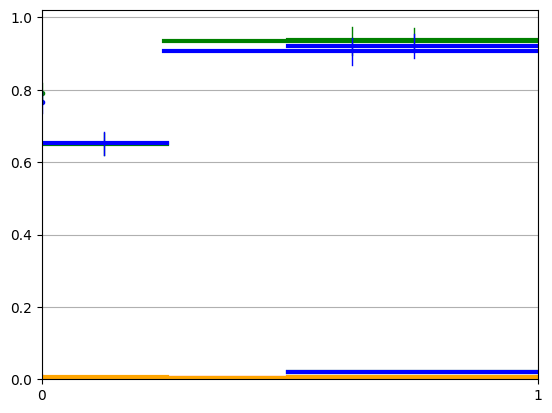

In [14]:
q = 0 # qubit to look at

dt = 0.01/len(code['0'].schedule)

if q in code['0'].color:
    ty = 'code'
else:
    ty = 'aux'
print(ty)

circuits = []
for logical in ['0', '1']:
    circuit = code[logical].circuit
    for basis in [code[logical].basis, code[logical].basis[::-1]]:
        circuits.append(circuit[basis])

colors = ['red', 'orange', 'blue', 'green']
ls = [0]
if ty=='code':
    ls.append(1)
for b in [0, 1]:
    for l in ls:
        j = b+2*l
        if q in code[str(l)].code_index:
            # see what errors this is sensitive to
            k = False
            for line in circuits[j].qasm().split('\n'):
                if 'code_qubit['+str(code[str(l)].code_index[q]) in line:
                    k = k or 'h' in line
            k = int(k)
        else:
            k = b
        for ts in alt_probs[j][q]:
            tav = (ts[0]+ts[1])/2
            for coords in alt_probs[j][q][ts]:
                prob = alt_probs[j][q][ts][coords]
                samples = alt_samples[j][q][ts][coords]
                dp = prob/(samples**0.5)
                color = colors[k+2*l]
                if ts[0]==ts[1]:
                    plt.scatter([np.mean(ts)],[prob], color=color, marker='.')
                else:
                    plt.plot([ts[0]-dt, ts[1]+dt], [prob, prob], color=color, linestyle='-', linewidth=3)
                plt.plot([tav,tav], [prob+dp, prob-dp], color=color, linestyle='-', linewidth=1)
plt.xlim((0,code[str(l)].T))
plt.xticks(range(code[str(l)].T+1))
plt.ylim(0)

plt.grid()
plt.savefig('error_plot/'+job_id+'_'+str(q)+'_'+ty+'.png')
plt.show()

Now we do the macroscopic analysis.

In [16]:
if shots is None:
    shots = 10000

In [17]:
from qiskit_qec.decoders import UnionFindDecoder
dec = UnionFindDecoder(code['0'], use_peeling=False)

try:
    with open('nums/'+job_id+'_'+str(shots)+'_uf.p', 'rb') as file:
        node_nums, flat_node_nums, error_nums = pickle.load(file)
    with open('log/'+job_id+'_'+str(shots)+'_uf.p', 'rb') as file:
        log_counts = pickle.load(file)
except:
    node_nums = {}
    flat_node_nums = {}
    error_nums = {}
    log_counts = []

    all_nodes = dg.graph.nodes()
    for j in range(4):
        shots = 0
        log_counts.append({})
        for string in counts[j]:

            clusters = dec.cluster(code[str(j%2)].string2nodes(string, all_logicals=True))
            clustered_nodes = {}
            for n, c in clusters.items():
                node = all_nodes[n]
                if not node.is_boundary:
                    if c in clustered_nodes:
                        clustered_nodes[c].append(node)
                    else:
                        clustered_nodes[c] = [node]
            for c, nodes in clustered_nodes.items():
                node_num = len(nodes)
                flat_node_num = len(code[str(j%2)].flatten_nodes(nodes))
                _, _, error_num = code[str(j%2)].check_nodes(nodes, minimal=True)
                for num, nums in [(node_num, node_nums), (flat_node_num, flat_node_nums), (error_num, error_nums)]:
                    if num in nums:
                        nums[num] += counts[j][string]/4
                    else:
                        nums[num] = counts[j][string]/4

            logical = str(dec.get_corrections(string, clusters)[0])
            if logical in log_counts[j]:
                log_counts[j][logical] += counts[j][string]
            else:
                log_counts[j][logical] = counts[j][string]

            shots += counts[j][string]
            if shots%100==0:
                print(shots)
                print(log_counts)

    with open('nums/'+job_id+'_'+str(shots)+'_uf.p', 'wb') as file:
        pickle.dump((node_nums, flat_node_nums, error_nums), file)

    with open('log/'+job_id+'_'+str(shots)+'_uf.p', 'wb') as file:
        pickle.dump(log_counts, file)

First we see what the logical outcomes were.

In [18]:
log_counts

[{'0': 10000}, {'0': 10000}, {'1': 10000}, {'1': 10000}]

If they are all good, we can plot the number of errors in the clusters.

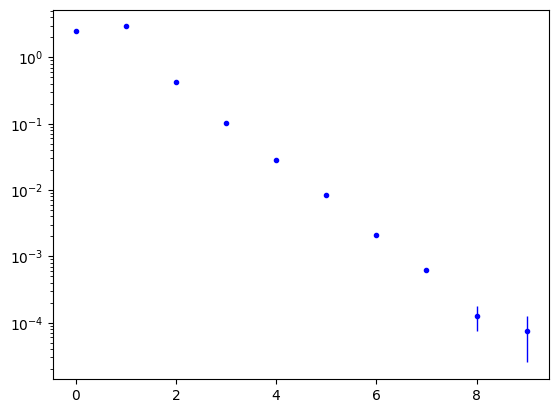

In [19]:
from matplotlib import pyplot as pyplot

def plot_nums(numss, labels=None, xticks=None):
    colors = ['blue', 'green']
    if not isinstance(numss, list):
        numss = [numss]
    for j, nums in enumerate(numss):
        xs, ys, yerrs = [], [], []
        for x, y in nums.items():
            if x is None:
                x = 0
            xs.append(x)
            y = y/shots
            yerrs.append(1/shots*0.5)
            ys.append(y)
        plt.errorbar(xs, ys, yerr=yerrs, color=colors[j], linewidth=0, elinewidth=1, marker='.')
        
        plt.yscale("log")
        #plt.xscale("log")
    
    if labels:
        plt.legend(labels)
    if xticks:
        plt.xticks(xticks)

plot_nums([error_nums])

plt.savefig('nums/'+job_id+'_'+str(shots)+'_uf.png')
plt.show()
